# Convolução no Domínio da Frequência
---

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import matplotlib.colors as cores

import seaborn as sns

import IPython.display as ipd


def rmse(a, b):
    return np.sqrt(np.absolute(a - b) ** 2).sum()/len(a)

def combo_plot(x, phase = False, db=False):
    # x[n]
    plt.figure(figsize=(16, 6))
    plt.plot(x)
    plt.show()
    
    X = np.fft.fft(zero_padding(x))
    w = np.linspace(0, 2 * np.pi, len(X))
    
    # |X[w]|
    plt.figure(figsize=(16, 6))
    if db:
        plt.plot(w, 20 * np.log10(np.absolute(X)))
    else:
        plt.plot(w, np.absolute(X))
    plt.show()
    
    # /_X[w]
    if (phase):
        plt.figure(figsize=(16, 6))
        plt.plot(w, np.angle(X))
        plt.show()

### FFT
---
A implementação do algoritmo de transformada rápida de Fourrier e funções associadas estão implementadas a seguir e  são:
 - `get_fft_index`
 - `zero_padding`
 - `fft`
 - `ifft`

A função `get_fft_index` calcula e retorna o vetor de índices dá transformada direta e inversa resultante da técnica de decimação na frequência. Os índices corretos são calculados através da reversão dos bits de cada índice inteiro do sinal de entrada.

A função `zero_padding` adiciona a um sinal `x` qualquer a quantidade de zeros necessária para que o comprimento de `x` seja uma potência de 2. Isto é necessário devido ao método utilizado para o cálculo da FFT, que só é possível com sinal de comprimento $2^k$. Não foi implementado uma FFT para sinais de tamanho quaisquer.

A transforma direta e a transformada inversa, `fft` e `ifft`, respctivamente, foram implementadas a partir do algoritmo de FFT Raiz 2 com decimção na frequência. As duas funções tem implementações quase idênticas, as únicas duas diferenças são o sinal de $k$ no termo $W_N$, para a FFT, $W_N^k$ e para a IFFT, $W_N^{-k}$, e por fim, uma constante multiplicativa presente na inversa, $\frac{1}{N}$.

In [2]:
def get_fft_index(i, width=9):
    i_fft = '{:0{width}b}'.format(i, width=width)
    return int(i_fft[::-1], 2)

In [3]:
def zero_padding(x):
    zeros = int(2 ** np.ceil(np.log2(len(x))) - len(x))
    return np.pad(x, (0, zeros), 'constant')

In [4]:
def fft(x, phase=0):
    N = len(x)
    g = x[:N//2] + x[N//2:]
    h = x[:N//2] - x[N//2:]
    if N > 2:
        g = fft(g, phase + 1)
        h = fft(h * (np.exp((-1j*2*np.pi)/N)**([k for k in range(len(h))])), phase + 1)
    
    X = np.concatenate([g, h])
    
    if phase == 0:
        X = X[[get_fft_index(i, int(np.log2(N))) for i in range(N)]]
        
    return X

In [5]:
def ifft(X, phase=0):
    N = len(X)
    g = X[:N//2] + X[N//2:]
    h = X[:N//2] - X[N//2:]
    if N > 2:
        g = ifft(g, phase + 1)
        h = ifft(h * (np.exp((-1j*2*np.pi)/N)**([-k for k in range(len(h))])), phase + 1)
    
    x = np.concatenate([g, h])
    
    if phase == 0:
        x = x[[get_fft_index(i, int(np.log2(N))) for i in range(N)]]
        return x/N
    else:
        return x

# Convulução por DFT em blocos
---

O cálculo da convulção atráves de tranformadas de Fourrier pode ser implementado de maneira eficiente fazendo uso de algortimos de transformada rápida de Fourrier, **FFT**. Outra maneira de melhorar a eficiência no cálculo da convolução é partir de segmentação em blocos, e dois algoritmos conhecidos para este fim são **sobreposição e soma** (*overlap-add*) e **sobreposição e armazenamento** (*overlap-save*). Os dois algoritmos estão implementados a seguir.

## Sobreposição e Soma

O algoritmo de sobreposição e soma se beneficia da linearidade do somatório para somar as caudas das convoluções de cada bloco.
 
# -COLOCAR IMAGEM-


In [6]:
def overlap_add(x, h, N = 512):
    M = len(h)
    No = N - M + 1
    L = int(np.ceil(len(x)/No))
    h = np.concatenate([h, np.zeros(No - 1)])
    H = fft(h)
    y = np.zeros(len(x) + M - 1, dtype=complex)
    for l in range(L):
        x_sub = x[l*No:(l+1)*No]
        N1 = len(x_sub)
        x_sub = np.concatenate([x_sub, np.zeros(N - len(x_sub))])
        X_sub = fft(x_sub)
        y_sub = ifft(X_sub * H)
        y[l*No: l*No + N] += y_sub[:N1 + M - 1]
    return y

## Sobreposição e Armazenamento

O algoritmo de sobreposição e armazenamento divide o sinal em blocos que contém interseção com os adjacentes, dessa forma é possível, calcular os termos das caudas de maneira completa e assim descartar elementos incompletos.
# COLOCAR IMAGEM

In [7]:
def overlap_save(x, h, N = 512):
    M = len(h)
    No = N - M + 1
    L = int(np.ceil(len(x)/No))
    h = np.concatenate([h, np.zeros(No - 1)])
    H = fft(h)
    y = np.zeros(0, dtype=complex)
    x = np.concatenate([np.zeros(M-1), x])
    for l in range(L):
        x_sub = x[(l*No):((l+1)*No) + M - 1]
        N1 = len(x_sub)
        x_sub = np.concatenate([x_sub, np.zeros(N - N1)])
        X_sub = fft(x_sub)
        y_sub = ifft(X_sub * H)
        y = np.concatenate([y, y_sub[M-1:N1 + M - 1]])
    return y

# Simulação #1
---

## Sinais
$$
x_{3000} = \left \{ \begin{matrix}
1, && 0\le n \le 3000 \\ 
0, && c.c. 
\end{matrix} \right.
$$


$$
x_{220} = \left \{ \begin{matrix}
1, && 0\le n \le 220 \\ 
0, && c.c. 
\end{matrix} \right.
$$

In [8]:
x_3000 = np.ones(3000)
x_220 = np.ones(220)

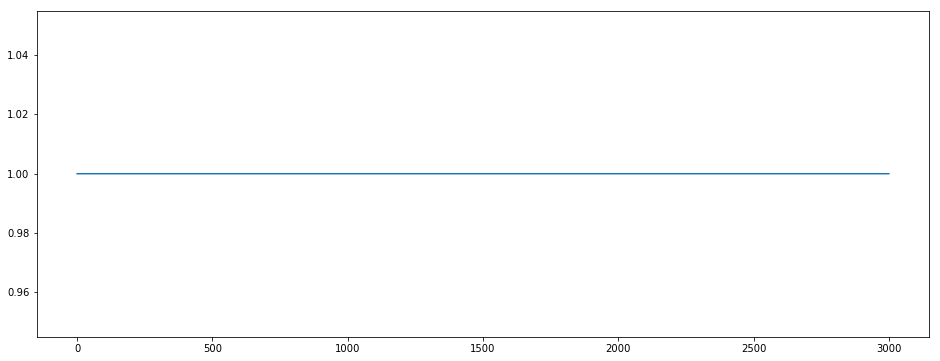

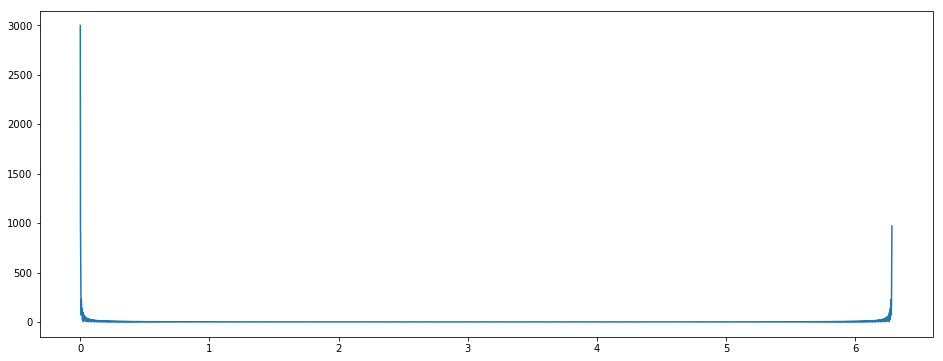

In [9]:
combo_plot(x_3000)

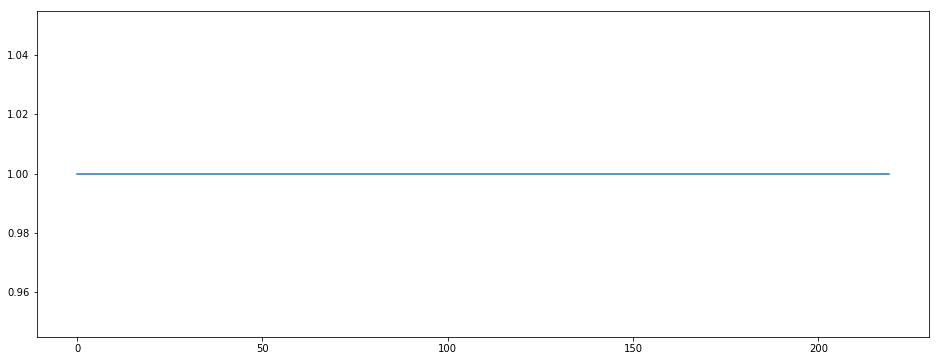

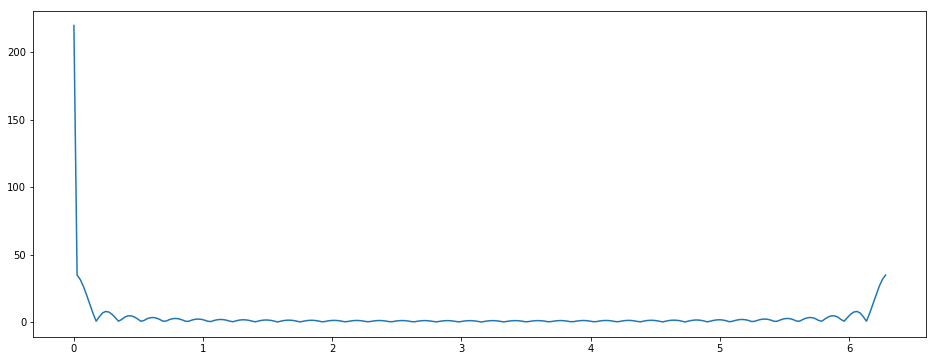

In [10]:
combo_plot(x_220)

Comprimento y_np:  3219


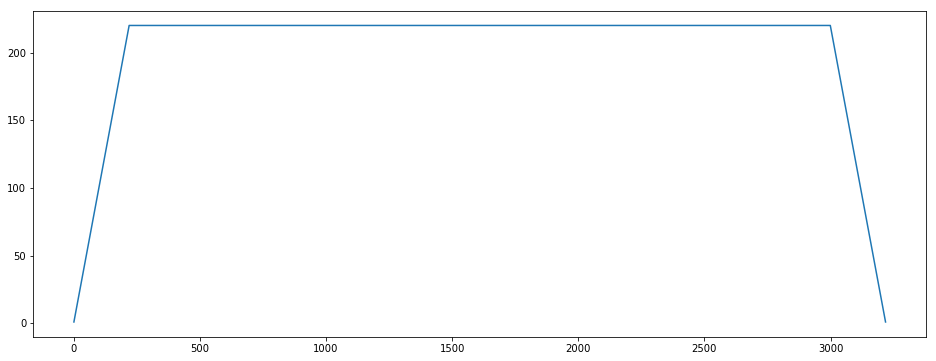

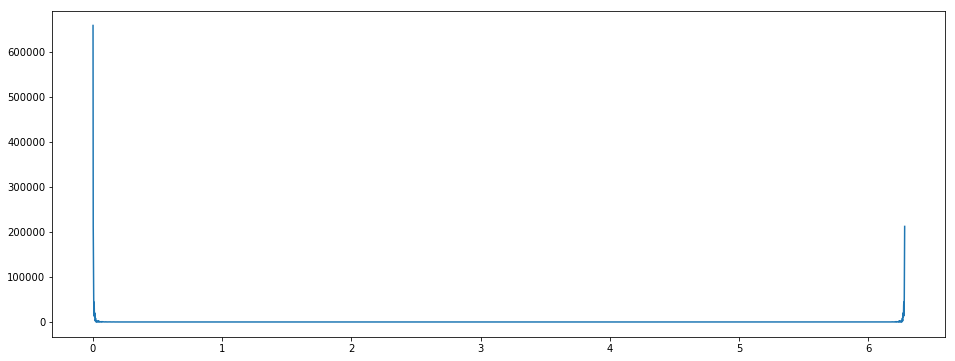

In [11]:
y_np = np.convolve(x_3000, x_220)
print('Comprimento y_np: ', len(y_np))
combo_plot(y_np)

Comprimento y_add:  3219
RMSE add: 5.76730867181e-13


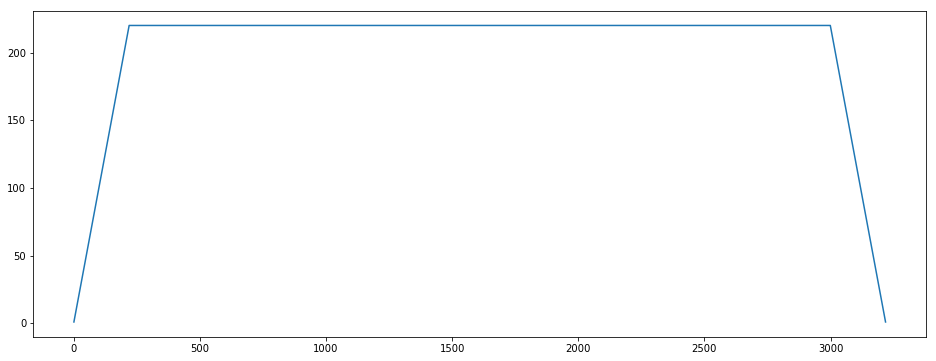

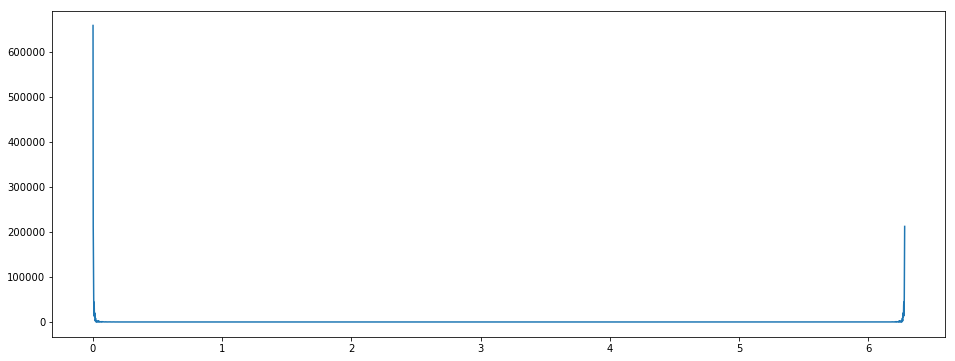

In [12]:
y_add = overlap_add(x_3000, x_220)
print('Comprimento y_add: ', len(y_add))
print('RMSE add:', rmse(y_np, y_add))
combo_plot(np.real(y_add))

Comprimento y_save:  3219
RMSE save: 1.06214538888e-13


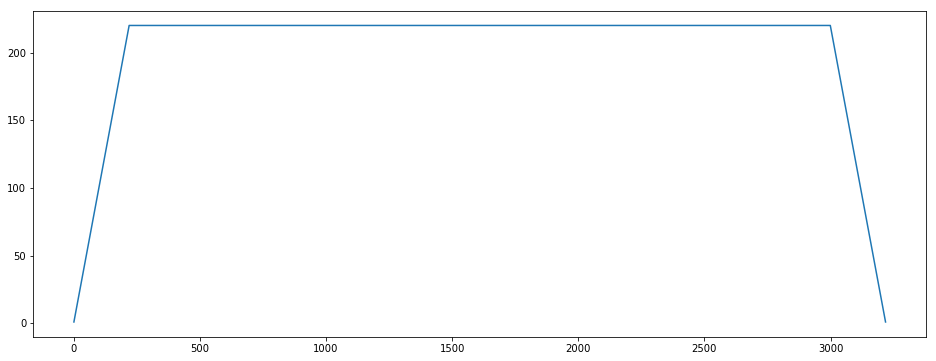

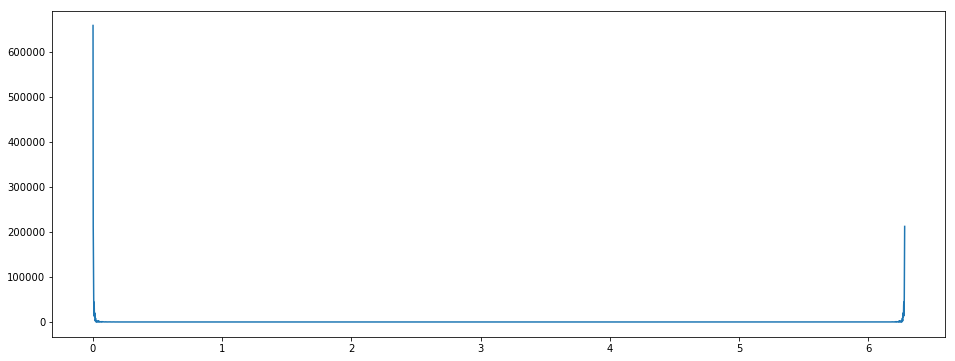

In [13]:
y_save = overlap_save(x_3000, x_220)
print('Comprimento y_save: ', len(y_save))
print('RMSE save:',rmse(y_np, y_save))
combo_plot(np.real(y_save))

# Simulação #2
---

# Sinais

$$
h[n] = \frac{\sin[0.325 \pi (n-62)]}{\pi (n-62)} 
       \left ( 0.5 - 0.5 \cos \left [ \frac{2 \pi n}{124} \right ] \right ), 0 \le n \le 124
$$

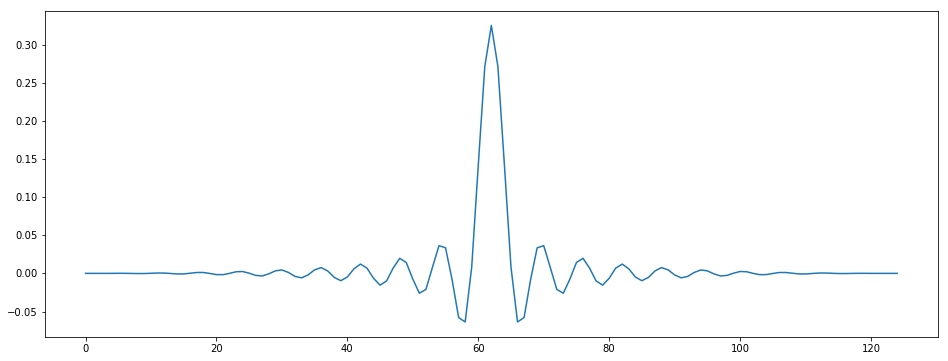

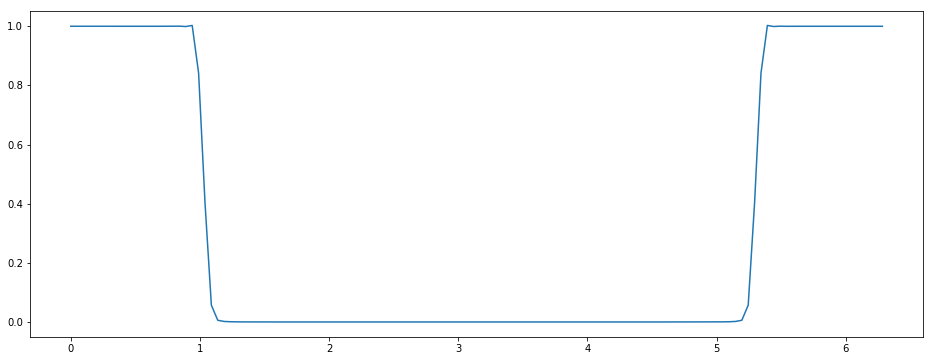

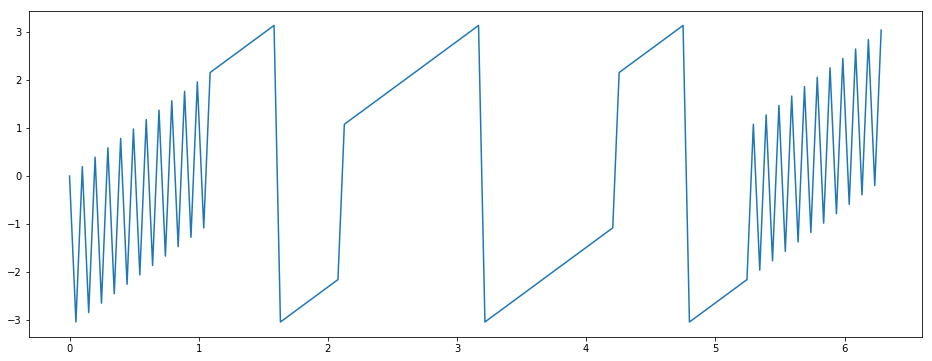

In [14]:
n_pb = np.arange(125)
h_pb = (.325 * np.sinc(.325 * (n_pb - 62)))*.5*(1 - np.cos((2 * np.pi * n_pb)/124))
combo_plot(h_pb, phase=True)

O sinal de voz foi gravado durante 10 segundos e com uma frequência de 8 kHz.

In [15]:
fs, voz = wavfile.read('voz.wav')
ipd.Audio(voz, rate=8000)

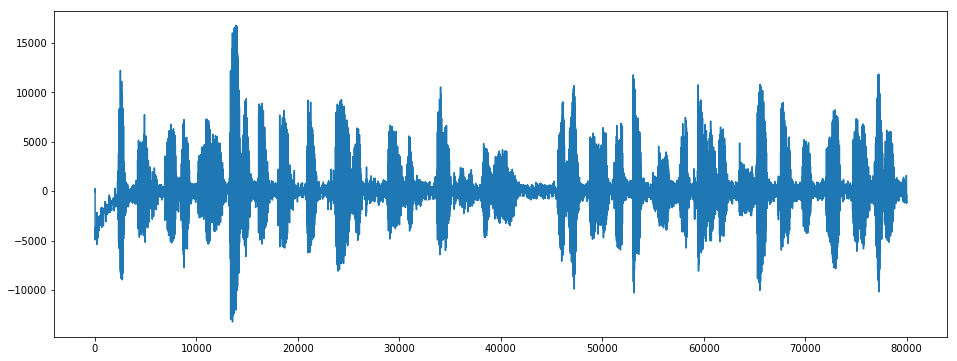

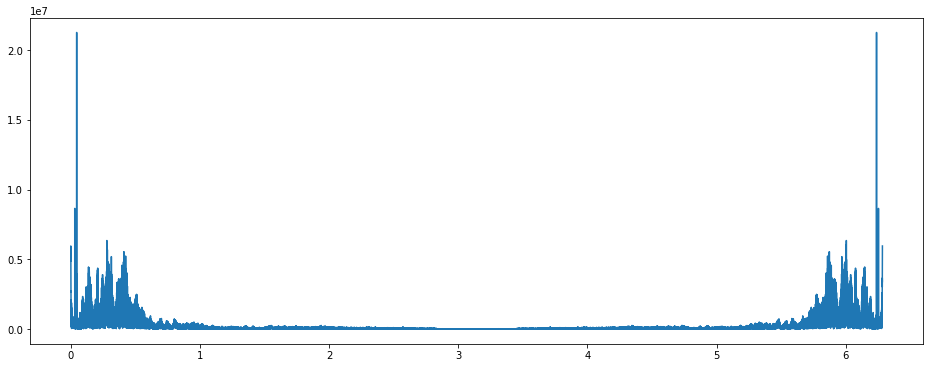

In [16]:
combo_plot(voz)

In [17]:
fs, ruido = wavfile.read('ruido.wav')
ipd.Audio(ruido, rate=8000)

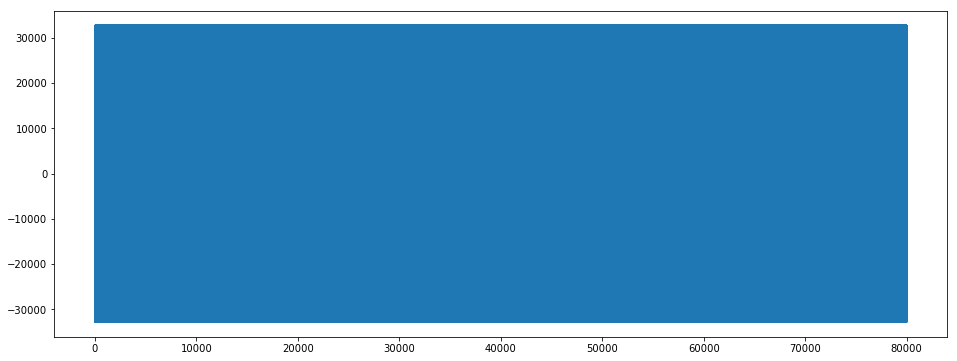

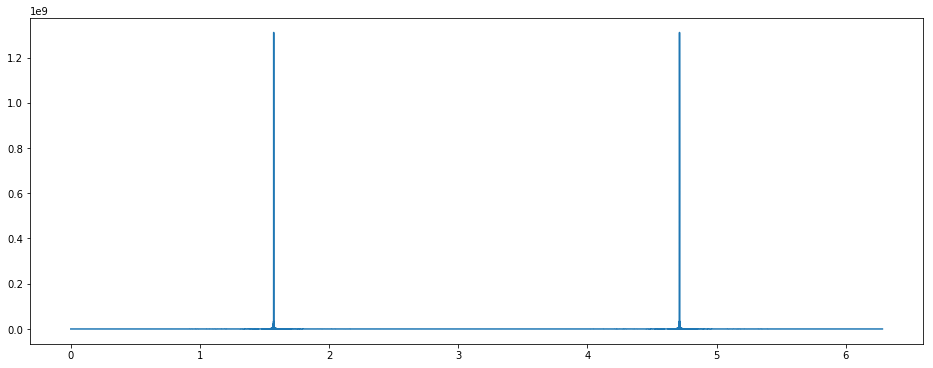

In [18]:
combo_plot(ruido)

In [19]:
voz_ruido = .1 * ruido + voz
ipd.Audio(voz_ruido, rate=8000)

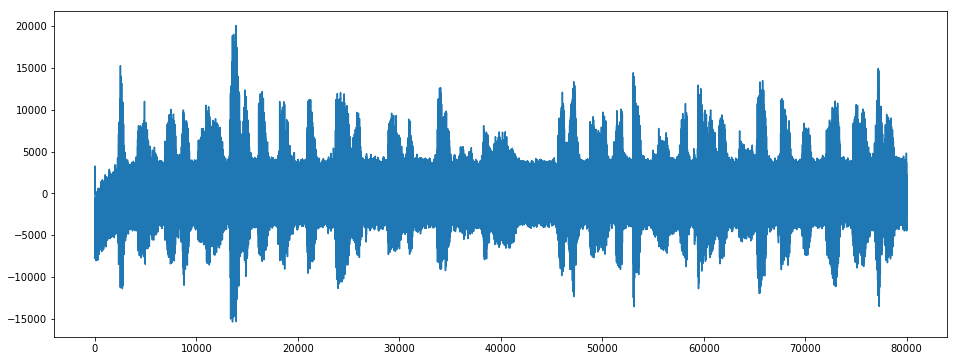

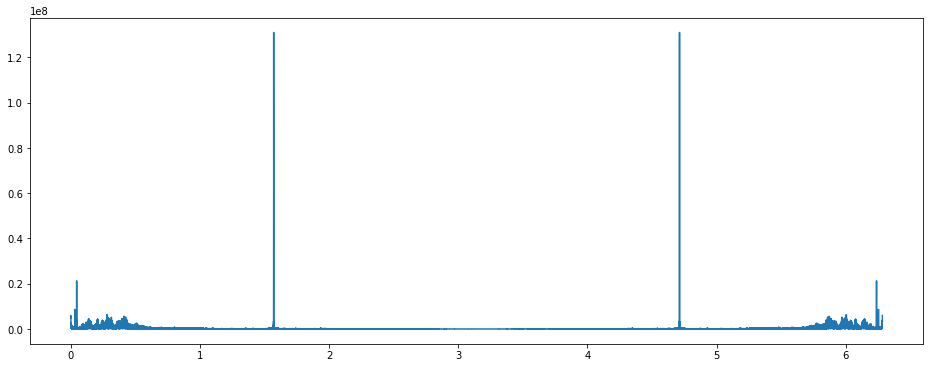

In [20]:
combo_plot(voz_ruido)

In [21]:
voz_pb_np = np.convolve(voz_ruido, h_pb) 
ipd.Audio(np.real(voz_pb_np), rate=8000)

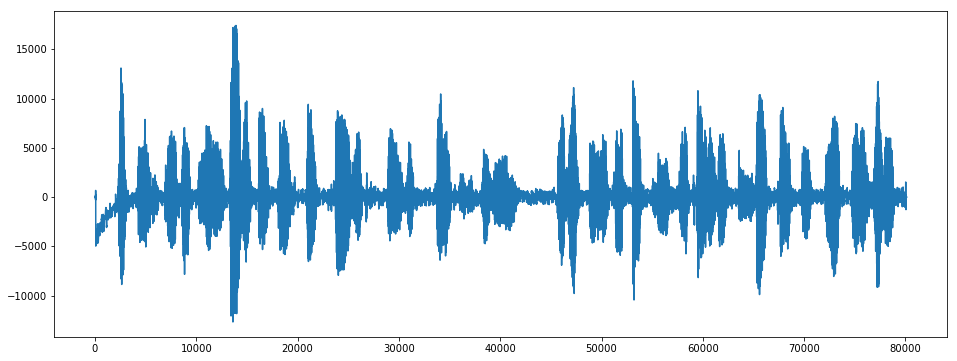

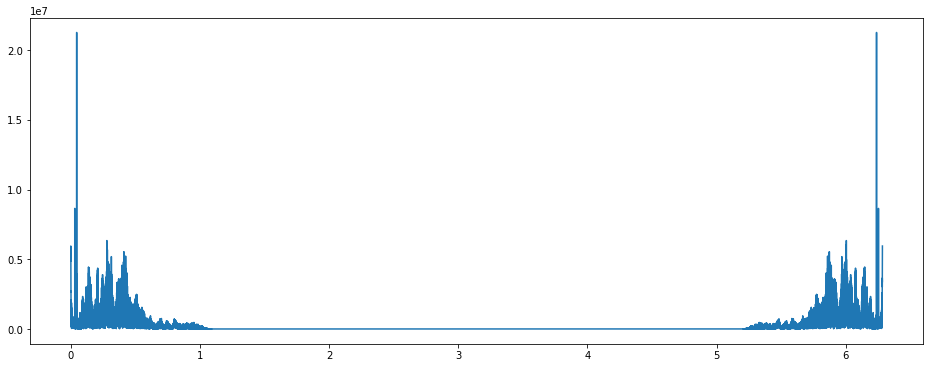

In [22]:
combo_plot(voz_pb_np)

In [23]:
voz_pb_add = overlap_add(voz_ruido, h_pb)
print('RMSE voz_pb_add:',rmse(voz_pb_np, voz_pb_add))
ipd.Audio(np.real(voz_pb_add), rate=8000)

RMSE voz_pb_add: 8.23854110894e-12


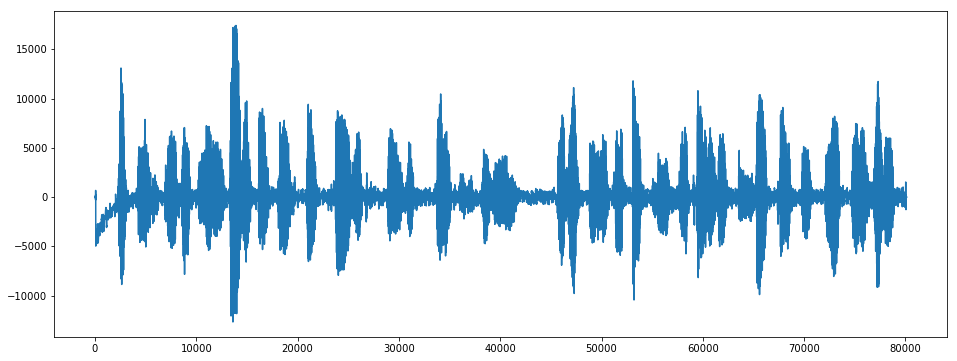

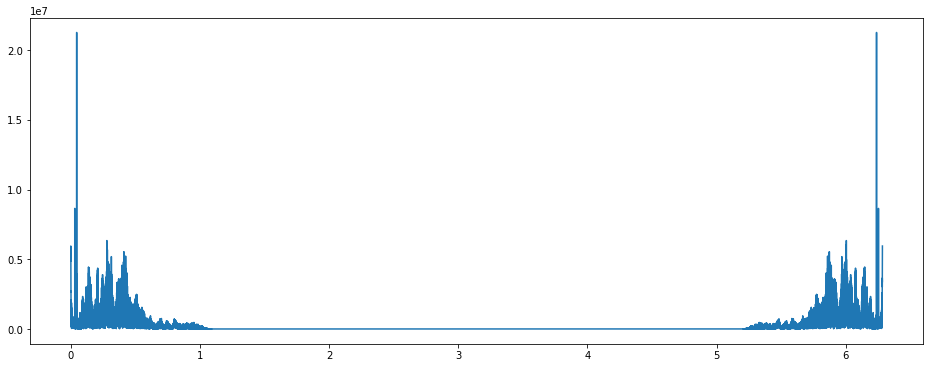

In [24]:
combo_plot(np.real(voz_pb_add))

In [25]:
voz_pb_save = overlap_save(voz_ruido, h_pb)
print('RMSE voz_pb_save:',rmse(voz_pb_save, voz_pb_add))
ipd.Audio(np.real(voz_pb_save), rate=8000)

RMSE voz_pb_save: 6.03654041213e-12


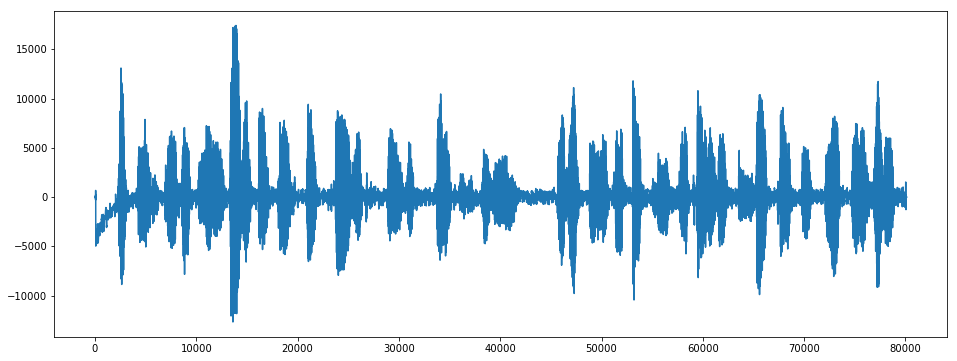

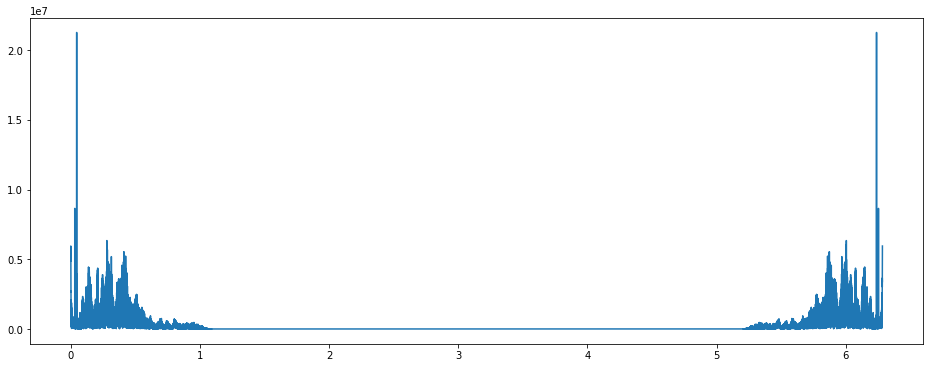

In [26]:
combo_plot(np.real(voz_pb_save))

# Simulação #3
---
## Espeficicação de filtro rejeita faixa

O filtro ideal rejeita faixa para este sinal possui resposta em frequência definida por:

$$
H(e^{j\Omega}) =
\left \{
    \begin{matrix}
        1, && \Omega \lt 1.8 kHz ou \Omega \gt 2.2kHz \\
        0, && 1.9kHz \le \Omega \le 2.1kHz
    \end{matrix}
\right .
$$

Abaixo o gráfico de magnitude da resposta em frequência de $H(e^{j\Omega})$:

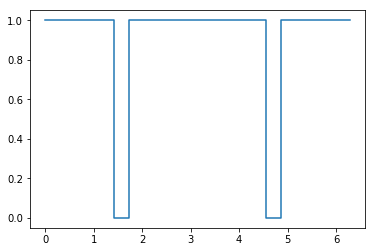

In [27]:
omega_rf = np.array([0, .45 * np.pi, .45 * np.pi, .55 * np.pi, .55 * np.pi,
                        (2 - .55) * np.pi, (2 - .55) * np.pi, (2 - .45) * np.pi, (2 - .45) * np.pi, 2 * np.pi])
H_rf = np.array([1, 1, 0, 0, 1, 1, 0, 0, 1, 1])

plt.plot(omega_rf, H_rf)
plt.show()

A resposta ao impulso associada é:
$$
h[n] = 
\left \{
    \begin{matrix}
        1 - \frac{\omega_{c2} - \omega_{c1}}{\pi}, && n = 0 \\
        \frac{\sin(\omega_{c1}n)}{\pi n} - \frac{\sin(\omega_{c2}n)}{\pi n}, && |n| \gt 0
    \end{matrix}
\right .
$$

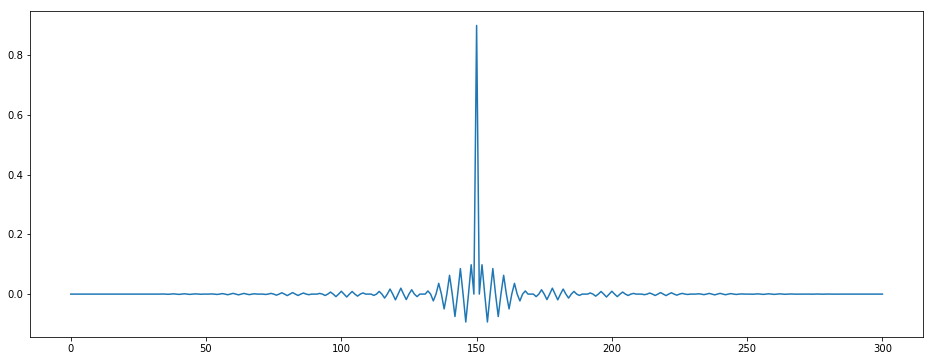

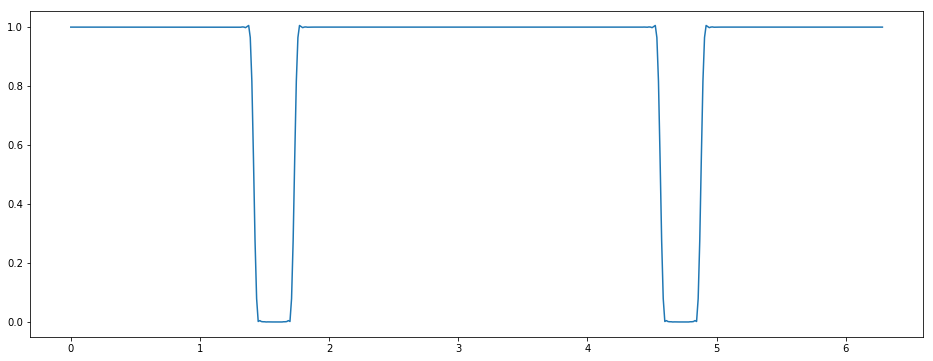

In [28]:
M_rf = 300
n_rf = np.arange(0, M_rf + 1)
h_rf = (np.divide(np.sin(.45 * np.pi * (n_rf - M_rf/2)), np.pi * (n_rf - M_rf/2), where= n_rf != M_rf/2) - np.divide(np.sin(.55 * np.pi * (n_rf - M_rf/2)), np.pi * (n_rf - M_rf/2), where= n_rf != M_rf/2)) * (.5*(1 - np.cos((2 * np.pi * n_rf)/M_rf)))
h_rf[M_rf//2] = 1 - (.55 - .45)
combo_plot(x=h_rf)

In [29]:
voz_rf_np = np.convolve(voz_ruido, h_rf)
ipd.Audio(np.real(voz_rf_np), rate=8000)

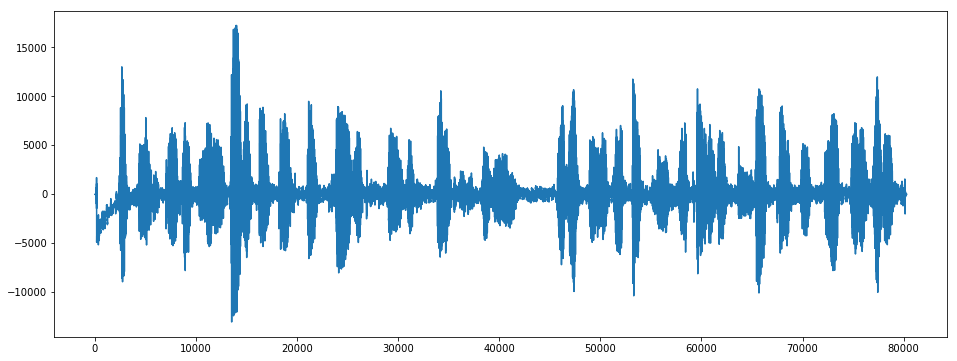

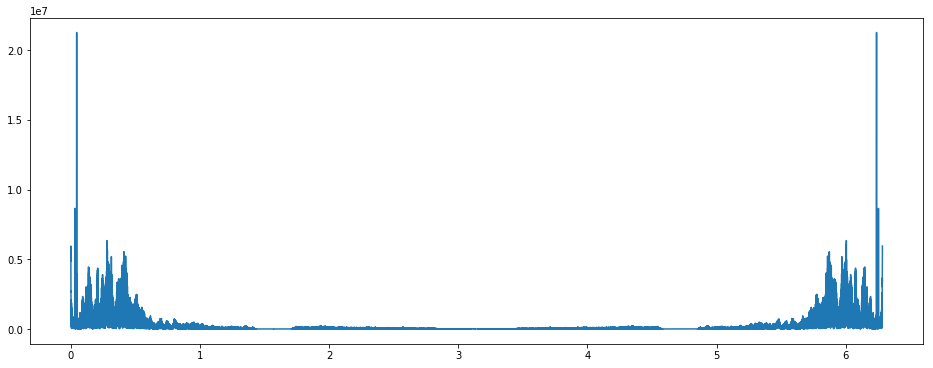

In [30]:
combo_plot(np.real(voz_rf_np))

In [31]:
voz_rf_add = overlap_add(voz_ruido, h_rf)
print('RMSE voz_rf_add:',rmse(voz_rf_np, voz_rf_add))
ipd.Audio(np.real(voz_rf_add), rate=8000)

RMSE voz_rf_add: 9.72797779103e-12


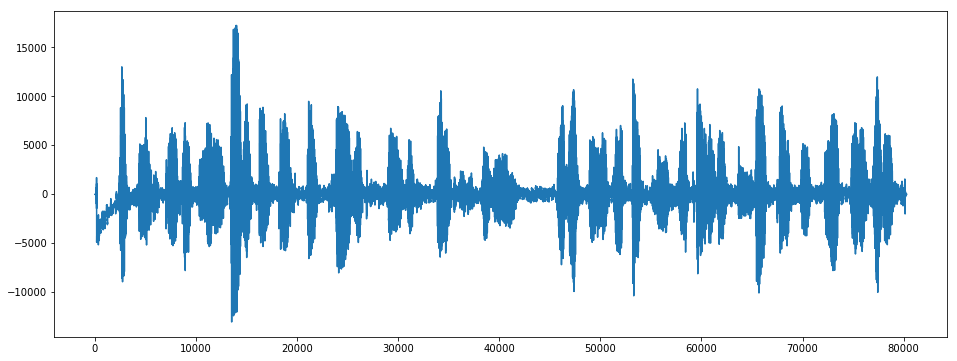

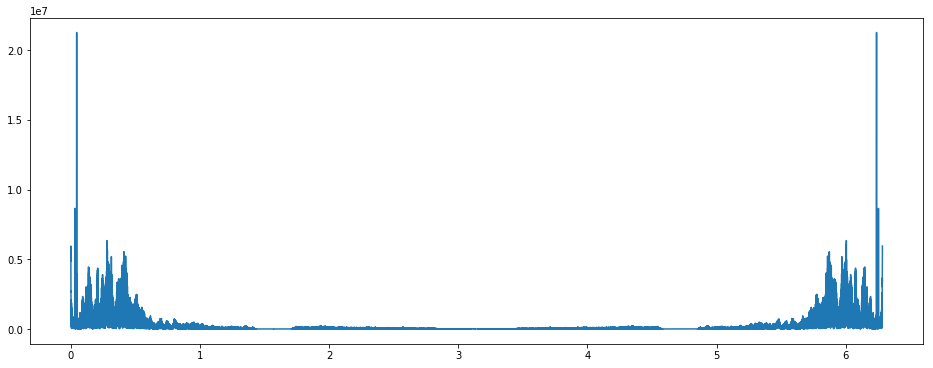

In [32]:
combo_plot(np.real(voz_rf_add))

In [33]:
voz_rf_save = overlap_save(voz_ruido, h_rf)
# print('RMSE voz_rf_add:',rmse(voz_rf_np, voz_rf_save))
ipd.Audio(np.real(voz_rf_save), rate=8000)

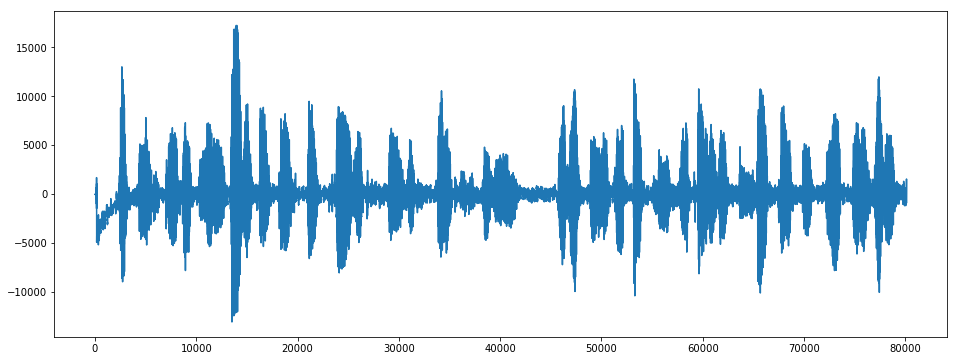

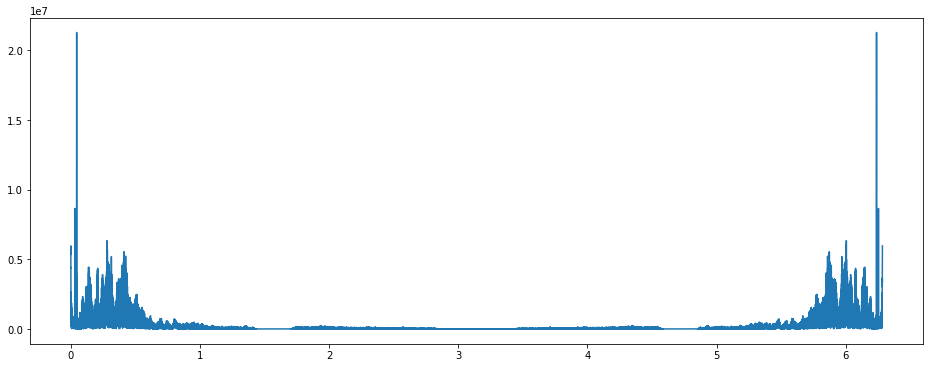

In [34]:
combo_plot(np.real(voz_rf_save))